# 시작

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

import os
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

from PIL import Image

from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import gc
import argparse
import random
from box import Box
import cv2
import cvlib as cv
import albumentations
import timm

In [2]:
# seed 고정
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# 데이터 전처리 함수

In [3]:
# ages 생성
def get_ages(x):
    if x < 30: return 0
    elif x < 60: return 1
    else: return 2

# genders 생성
def get_genders(x):
    if x == 'male': return 0
    else: return 1

# masks 생성
def get_masks(x):
    if x == 'normal': return 2
    elif x == 'incorrect_mask': return 1
    else: return 0

# age_cats 생성
def get_age_cats(x):
    if x < 20: return 0
    elif x < 30: return 1
    elif x < 40: return 2
    elif x < 50: return 3
    elif x < 60: return 4
    else: return 5

# labels 생성
def get_labels(masks, genders, ages):
    return masks * 6 + genders * 3 + ages

# label_cats 생성
def get_label_cats(masks, genders, ages):
    return masks * 12 + genders * 6 + ages

# 마스크 이상치 변경
def swap_mask(swap_li : list, df : pd.DataFrame) -> pd.DataFrame:
    swap_df = df.copy()
    for swap_id in swap_li:
        _swap_df = swap_df[swap_df['id'] == swap_id]
        
        normal_swap_df = _swap_df[_swap_df['mask'] == 'normal']
        incorrect_mask_swap_df = _swap_df[_swap_df['mask'] == 'incorrect_mask']
        
        normal_path = normal_swap_df['path'].values[0]
        incorrect_mask_path = incorrect_mask_swap_df['path'].values[0]
        
        swap_df.loc[normal_swap_df.index, 'path'] = incorrect_mask_path
        swap_df.loc[incorrect_mask_swap_df.index, 'path'] = normal_path
    
    return swap_df

# train_df + mask 결측치 처리
def make_train_df(df : pd.DataFrame, swap_mask_li : list, cfg) -> pd.DataFrame:
    train_df = []
    
    for line in df.iloc:
        for file in list(os.listdir(os.path.join(cfg.train_image_dir, line['path']))):
            if file[0] == '.':
                continue
            
            mask = file.split('.')[0]
            gender = line['gender']
            age = line['age']
            
            masks = get_masks(mask)
            genders = get_genders(gender)
            ages = get_ages(age)
            age_cats = get_age_cats(age)
            
            data = {
                'id' : line['id'],
                'mask' : mask,
                'gender' : gender,
                'age' : age,
                'masks' : masks,
                'genders' : genders,
                'ages' : ages,
                'age_cats' : age_cats,
                'labels': get_labels(masks = masks, genders = genders, ages = ages),
                'label_cats': get_label_cats(masks = masks, genders = genders, ages = age_cats),
                'path': os.path.join(cfg.train_image_dir, line['path'], file),
            }
            
            train_df.append(data)
            
    train_df = pd.DataFrame(train_df)
    
    train_df['idx'] = train_df.index
    
    train_df = swap_mask(swap_li = swap_mask_li, df = train_df)
    
    return train_df

# 성별 이상치 처리
def swap_gender(swap_li : list, df : pd.DataFrame) -> pd.DataFrame:
    swap_df = df.copy()
    for swap in swap_li:
        swap_id, swap_gender = swap
        swap_df.loc[swap_df[swap_df['id'] == swap_id].index, 'gender'] = swap_gender
    return swap_df

# 사람 나누기 데이터 + 성별 결측치 처리
def preprocessing_df(df : pd.DataFrame, swap_gender_li : list) -> pd.DataFrame:
    
    preprocessing_df = df.copy()
    preprocessing_df = swap_gender(swap_li = swap_gender_li, df = preprocessing_df)
    
    preprocessing_df['ages'] = preprocessing_df['age'].apply(lambda x : get_ages(x))
    preprocessing_df['genders'] = preprocessing_df['gender'].apply(lambda x : get_genders(x))
    
    preprocessing_df['cv_taget_col'] = 'ages' + '_' + preprocessing_df['ages'].astype(str) + '_' + 'genders' + '_' + preprocessing_df['genders'].astype(str)
    
    return preprocessing_df

# 이상치 시각화 함수

In [4]:
# 이상치 이미지 시각화
def show_img(img_id_li, df, cfg):
    for img_id in img_id_li:
        get_df = df[df['id'] == img_id]
        
        img_age = get_df['age'].tolist()[0]
        img_gender = get_df['gender'].tolist()[0]
        
        img_path = get_df['path'].tolist()[0]
        img_path = os.path.join(cfg.train_image_dir, img_path)
        img_name_li = sorted(list(os.listdir(img_path)))
        
        fig, ax = plt.subplots(1, 7, figsize = (30, 15))
        ax = ax.flatten()
        
        idx = 0
        for _img_name in img_name_li:
            if _img_name[0] == '.': continue
            
            if _img_name.split('.')[0] == 'normal': imag_name = 'normal'
            elif _img_name.split('.')[0] == 'incorrect_mask': imag_name = 'incorrect_mask'
            else: imag_name = 'mask'
            
            get_img_path = os.path.join(img_path, _img_name)
            
            img = Image.open(get_img_path)
            img = np.array(img)
            ax[idx].imshow(img)
            ax[idx].set_title(f'{img_id} / {img_age} / {img_gender} / {imag_name}')
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            idx += 1
            
        plt.show()

# image path로 이미지 시각화
def path_li_show_img(path_li):
    fig, ax = plt.subplots(1, 7, figsize = (30, 15))
    ax = ax.flatten()
    idx = 0
    for path in path_li:
        image_name = path.split('/')[-1]
        img = Image.open(path)
        img = np.array(img)
        ax[idx].imshow(img)
        ax[idx].set_title(f'{image_name}')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        idx += 1
    plt.show()

# 데이터 설정 함수

In [5]:
# val_idx 생성
def get_val_idx(df : pd.DataFrame, target_col : str):
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)
    for trn_idx, val_idx in skf.split(df, df[target_col]):
        yield val_idx

class CustomDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cfg, transform : transforms = None, mode : bool = True):
        self.mode = mode
        self.df = df
        if self.mode:
            self.img_paths = self.df['path'].tolist()
            self.targets = self.df[cfg.tagets_col].tolist()
            self.split_targets = self.df[cfg.split_col].tolist()
        else:
            self.img_paths = [os.path.join(cfg.submission_image_dir, img_id) for img_id in self.df.ImageID]
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        
        if self.transform:
            image = self.transform(image)
        
        # 이 부분에 해당 라벨에 따른 데이터 변환 여부 추가
        # val 데이터의 경우 데이터 변환이 일어나면 안되기 때문에
        # if self.데이터 변환해주는 transform:
        #     if self.targets[index].data == labels: <- 확률적으로
        #          image = self.데이터 변환해주는 transform(image)
        # 데이터 변환
        
        if self.mode:
            targets = torch.tensor(self.targets[index])
            return image, targets
        
        else: return image

    def __len__(self):
        return len(self.img_paths)

class StratifiedSampler(torch.utils.data.Sampler):
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.cpu().numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits = n_batches, shuffle = shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)

# 모델

In [6]:
class CreateModel(nn.Module):
    def __init__(self, cfg , pretrained : bool = True):
        super(CreateModel, self).__init__()
        self.model = timm.create_model(cfg.timm_model_name, pretrained = pretrained, num_classes = cfg.num_classes)

    def forward(self, img):
        out = self.model(img)
        return out

In [7]:
def get_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def get_acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [8]:
def model_train(model, optimizer, criterion, data_loader):
    model.train()
    
    train_loss = 0
    real_pred_li = []
    label_pred_li = []
    
    for images, targets in data_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # GA 추가시 아래 부분에 추가하기
        #############################
        
        benign_outputs = model(images)
        loss = criterion(benign_outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        predicted = benign_outputs.argmax(dim=-1)
        
        label_pred_li.extend(predicted.detach().cpu().numpy())
        real_pred_li.extend(targets.cpu().numpy())
        
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    train_loss /= len(data_loader)
    train_acc = get_acc_score(y_true = real_pred_li, y_pred = label_pred_li)
    train_fi_score = get_f1_score(y_true = real_pred_li, y_pred = label_pred_li)

    return train_loss, train_acc, train_fi_score

def model_eval(model, criterion, data_loader):
    model.eval()
    
    val_loss = 0
    real_pred_li = []
    label_pred_li = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device)

            benign_outputs = model(images)
            loss = criterion(benign_outputs, targets)

            val_loss += loss.item()

            predicted = benign_outputs.argmax(dim=-1)
        
            label_pred_li.extend(predicted.cpu().numpy())
            real_pred_li.extend(targets.cpu().numpy())
    
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    val_loss /= len(data_loader)
    val_acc = get_acc_score(y_true = real_pred_li, y_pred = label_pred_li)
    val_fi_score = get_f1_score(y_true = real_pred_li, y_pred = label_pred_li)
   
    return val_loss, val_acc, val_fi_score

In [9]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [10]:
def get_val_pred_li(model, data_loader):
    model.eval()
    real_pred_li = []
    label_pred_li = []
    ensemble_pred_li = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            output = model(images)
            
            label = output.argmax(dim=-1)
            label_pred_li.extend(label.cpu().numpy())
            
            ensemble_label = output.softmax(1)
            ensemble_pred_li.append(ensemble_label.cpu().numpy())
            
            real_pred_li.extend(targets.cpu().numpy())
            
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
#     real_pred_li = [label_cats2labels[i] for i in real_pred_li]
    
    return label_pred_li, np.concatenate(ensemble_pred_li), real_pred_li

def get_submission_pred_li(model, data_loader):
    model.eval()
    label_pred_li = []
    ensemble_pred_li = []
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            output = model(images)
            
            label = output.argmax(dim=-1)
            label_pred_li.extend(label.cpu().numpy())
            
            ensemble_label = output.softmax(1)
            ensemble_pred_li.append(ensemble_label.cpu().numpy())
            
#     label_pred_li = [label_cats2labels[i] for i in label_pred_li]
    
    return label_pred_li, np.concatenate(ensemble_pred_li)

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


# https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

# 환경 설정

In [ ]:
timm.list_models(pretrained=True)

In [12]:
# 이상치 list
# swap_gender_li = ['id', '바꿀 성별']
# swap_mask_li = ['id']
swap_gender_li = [['006359', 'male'], ['006360', 'male'], ['006361', 'male'], ['006362', 'male'], ['006363', 'male'], ['006364', 'male'], ['001498-1', 'female']]
swap_mask_li = ['000020', '004418', '005227']

timm_model = 'regnety_002'


config = {
    'seed' : 22,
    
    'image_size' : [512, 384],
    'image_normal_mean' : [0.5, 0.5, 0.5],
    'image_normal_std' : [0.2, 0.2, 0.2],
    
    'num_workers' : 3,
    'epochs' : 30,
    'batch_size' : 64,
    'lr' : 0.00009,
    'oof' : 5,
    'num_classes' : 6,
    
    # cel
    # labelsmoothing
    # focal
    # f1
    'loss' : 'labelsmoothing',
    'smoothing' : 0.1,
    
    'train_data_name' : 'train.csv',
    'train_data_dir' : '/opt/ml/input/data/train',
    'train_image_dir' : '/opt/ml/input/data/train/images',
    
    'submission_data_name' : 'info.csv',
    'submission_data_dir' : '/opt/ml/input/data/eval',
    'submission_image_dir' : '/opt/ml/input/data/eval/images',
    'submission_dir' : './submission',
    
    'model_dir' : './model',
    # 저장할 모델병
    'model_name' : f'{timm_model}_age0',
    # timm 에 존재하는 모델 이름
    'timm_model_name' : timm_model,
    # 학습 타겟
    'tagets_col' : 'labels',
    'split_col' : 'label_cats',
    'cv_taget_col' : 'cv_taget_col',
    # 저장할 파일명
    'file_name' : f'{timm_model}_age0.csv',
}


device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

In [13]:
# 변환할 transform
from torchvision.transforms import Resize, ToTensor, Normalize, Lambda, RandomHorizontalFlip, ToPILImage, Grayscale, CenterCrop

def image_face_crop(image):
    image = np.array(image)
    face, confidence = cv.detect_face(image)
    if not face : return image
    x, y, w, h = face[0]
    H, W, C = image.shape
    image = image[max(y - 100, 0) : min(h + 100, H), max(0 , x - 100) : min(w + 100, W)]
    return image

transform = {
        "train": transforms.Compose(
            [
#                 CenterCrop(384),
#                 Lambda(image_face_crop),
#                 ToPILImage(),
#                 Resize(config.image_size, Image.BILINEAR),
                ToTensor(),
#                 RandomHorizontalFlip(p = 0.5),
                Normalize(mean=config.image_normal_mean, std=config.image_normal_std),
                Grayscale(num_output_channels = 3),
                
            ]
        ),
        "val": transforms.Compose(
            [
#                 CenterCrop(384),
#                 Resize(config.image_size, Image.BILINEAR),
                ToTensor(),
                Normalize(mean=config.image_normal_mean, std=config.image_normal_std),
                Grayscale(num_output_channels = 3),
            ]
        ),
    }

# 데이터 로드

In [14]:
seed_everything(config.seed)

In [15]:
df = pd.read_csv(os.path.join(config.train_data_dir, config.train_data_name))
submission = pd.read_csv(os.path.join(config.submission_data_dir, config.submission_data_name))

# 이상치 시각화

In [20]:
# show_img(img_id_li =['000020', '004418', '005227', '006359', '006360', '006361', '006362', '006363', '006364', '001498-1'], df = df, cfg = config)

# 학습

In [18]:
pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.cv_taget_col)

total_start_time = time.time()

for fold_num in range(1, config.oof + 1):
    fold_start_time = time.time()
    
    # trn, val 데이터 셋
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[val_id_df['id'].tolist(), :].reset_index()
    trn_df = train_df.set_index('id').loc[trn_id_df['id'].tolist(), :].reset_index()
    
    trn_df = trn_df[(trn_df['labels'] >= 0) & (trn_df['labels'] <= 5)].reset_index(drop = True)
    val_df = val_df[(val_df['labels'] >= 0) & (trn_df['labels'] <= 5)].reset_index(drop = True)

    trn_df['labels'] = trn_df['labels'].apply(lambda x : x % 6)
    val_df['labels'] = val_df['labels'].apply(lambda x : x % 6)
    
    # 이 부분에 클래스가 적은 데이터 증강 함수 추가
    ########################################3
    
    # 배치 단위 데이터 생성 부분
    #########################
    
    # dataset 구축
    trn_dataset = CustomDataset(df = trn_df,
                                cfg = config,
                                transform = transform['train'],
                                mode = True,
                               )
    
    train_loder = DataLoader(trn_dataset,
                           batch_size = config.batch_size,
                           num_workers = config.num_workers,
                           shuffle = True,
                            )
    
    
#     sampler = StratifiedSampler(y = np.array(trn_dataset.split_targets), 
#                                 batch_size = config.batch_size, 
#                                 shuffle = True)
    
#     train_loder = DataLoader(trn_dataset,
#                              num_workers = config.num_workers,
#                              batch_sampler = sampler)
    
    
    val_dataset = CustomDataset(df = val_df,
                                cfg = config,
                                transform = transform['val'],
                                mode = True,)
    
    val_loder = DataLoader(val_dataset,
                           batch_size = config.batch_size,
                           num_workers = config.num_workers,
                           shuffle = False,)
    
    # 모델 정의
    model = CreateModel(cfg = config, pretrained = True).to(device)

    # loss 설정
    if config.loss == 'cel':
        criterion = nn.CrossEntropyLoss()
    elif config.loss == 'labelsmoothing':
        criterion = LabelSmoothingLoss(classes=config.num_classes, smoothing=config.smoothing, dim=-1)
    elif config.loss == 'focal':
        criterion = FocalLoss(weight=None, gamma=2., reduction='mean')
    elif config.loss == 'f1':
        criterion = F1Loss(classes=config.num_classes, epsilon=1e-7)
    else:
        print('not loss')
    
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, amsgrad=True)
    
    # scheduler 설정
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09, patience = 5)
   
    # besf_metric 설정
    besf_fi = 0
#     min_val_loss = float("inf")
#     early_stopping_count = 0
    
    for epoch in tqdm(range(1, config.epochs + 1)):
        epoch_start_time = time.time()
        
        train_loss, train_acc, train_fi_score = model_train(model = model, 
                                                            optimizer = optimizer, 
                                                            criterion = criterion, 
                                                            data_loader = train_loder)
        
        val_loss, val_acc, val_fi_score, = model_eval(model = model,
                                                      criterion = criterion,
                                                      data_loader = val_loder)
        
        # 학습률
        now_lr = get_lr(optimizer = optimizer)
        
        epoch_end_time = time.time()
        
        now = datetime.datetime.now()
        nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
        print(f'''{fold_num}fold, epoch: {epoch}, lr: {now_lr}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, train_f1: {train_fi_score:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, val_fi: {val_fi_score:.4f}, 학습시간: {epoch_end_time - epoch_start_time} ''')
        print(nowDatetime)
        # 스케줄러
        scheduler.step(val_loss)
        
        # 모델 저장
#         if val_loss < min_val_loss:
#             min_val_loss = val_loss
#             torch.save(model.state_dict(), os.path.join(config.model_dir, f'{fold_num}fold_{config.model_name}.pt'))
#             print(val_loss, '모델 저장')
#             early_stopping_count = 0
            
        if besf_fi < val_fi_score:
            besf_fi = val_fi_score
            torch.save(model.state_dict(), os.path.join(config.model_dir, f'{fold_num}fold_{config.model_name}.pt'))
            print(besf_fi, '모델 저장 \n')
#             early_stopping_count = 0

#         else:
#             early_stopping_count += 1
#             if early_stopping_count == 5:
#                 print('early_stopping')
#                 break
    
    fold_end_time = time.time()
    
    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time} \n')
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_end_time = time.time()
print(f'총 훈련 시간: {total_end_time - total_start_time}')

  3%|▎         | 1/30 [00:51<25:06, 51.94s/it]

1fold, epoch: 1, lr: 9e-05, train_loss: 0.9471, train_acc: 0.8061, train_f1: 0.5713, val_loss: 0.7514, val_acc: 0.8693, val_fi: 0.6167, 학습시간: 51.849294900894165 
2022-02-28 11:20:13
0.6167470141117827 모델 저장 



  7%|▋         | 2/30 [01:43<24:14, 51.94s/it]

1fold, epoch: 2, lr: 9e-05, train_loss: 0.6228, train_acc: 0.9338, train_f1: 0.8061, val_loss: 0.7325, val_acc: 0.8815, val_fi: 0.7382, 학습시간: 51.852166414260864 
2022-02-28 11:21:04
0.7381546711815782 모델 저장 



 10%|█         | 3/30 [02:35<23:21, 51.92s/it]

1fold, epoch: 3, lr: 9e-05, train_loss: 0.5384, train_acc: 0.9819, train_f1: 0.9594, val_loss: 0.7636, val_acc: 0.8667, val_fi: 0.7497, 학습시간: 51.804616928100586 
2022-02-28 11:21:56
0.7496709334206996 모델 저장 



 13%|█▎        | 4/30 [03:28<22:34, 52.09s/it]

1fold, epoch: 4, lr: 9e-05, train_loss: 0.5108, train_acc: 0.9934, train_f1: 0.9901, val_loss: 0.7628, val_acc: 0.8815, val_fi: 0.7550, 학습시간: 52.38928842544556 
2022-02-28 11:22:49
0.7550067848356545 모델 저장 



 17%|█▋        | 5/30 [04:20<21:45, 52.23s/it]

1fold, epoch: 5, lr: 9e-05, train_loss: 0.5021, train_acc: 0.9973, train_f1: 0.9947, val_loss: 0.7886, val_acc: 0.8772, val_fi: 0.7246, 학습시간: 52.55492448806763 
2022-02-28 11:23:41


 20%|██        | 6/30 [05:13<21:00, 52.52s/it]

1fold, epoch: 6, lr: 9e-05, train_loss: 0.4990, train_acc: 0.9975, train_f1: 0.9977, val_loss: 0.7631, val_acc: 0.8836, val_fi: 0.7501, 학습시간: 53.19473052024841 
2022-02-28 11:24:35


 23%|██▎       | 7/30 [06:08<20:18, 52.97s/it]

1fold, epoch: 7, lr: 9e-05, train_loss: 0.4973, train_acc: 0.9981, train_f1: 0.9977, val_loss: 0.7789, val_acc: 0.8817, val_fi: 0.7222, 학습시간: 54.008882999420166 
2022-02-28 11:25:29


 27%|██▋       | 8/30 [07:00<19:25, 52.96s/it]

1fold, epoch: 8, lr: 9e-05, train_loss: 0.4938, train_acc: 0.9993, train_f1: 0.9988, val_loss: 0.7614, val_acc: 0.8865, val_fi: 0.7678, 학습시간: 52.846988677978516 
2022-02-28 11:26:22
0.7678124829787207 모델 저장 



 30%|███       | 9/30 [07:55<18:40, 53.35s/it]

1fold, epoch: 9, lr: 9e-06, train_loss: 0.4928, train_acc: 0.9994, train_f1: 0.9994, val_loss: 0.7552, val_acc: 0.8929, val_fi: 0.7596, 학습시간: 54.26571989059448 
2022-02-28 11:27:16


 33%|███▎      | 10/30 [08:48<17:49, 53.46s/it]

1fold, epoch: 10, lr: 9e-06, train_loss: 0.4913, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7549, val_acc: 0.8931, val_fi: 0.7607, 학습시간: 53.71719932556152 
2022-02-28 11:28:10


 37%|███▋      | 11/30 [09:42<16:57, 53.56s/it]

1fold, epoch: 11, lr: 9e-06, train_loss: 0.4911, train_acc: 0.9999, train_f1: 0.9998, val_loss: 0.7549, val_acc: 0.8870, val_fi: 0.7627, 학습시간: 53.79470682144165 
2022-02-28 11:29:03


 40%|████      | 12/30 [10:35<16:00, 53.38s/it]

1fold, epoch: 12, lr: 9e-06, train_loss: 0.4907, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7573, val_acc: 0.8910, val_fi: 0.7617, 학습시간: 52.963486433029175 
2022-02-28 11:29:56


 43%|████▎     | 13/30 [11:29<15:09, 53.51s/it]

1fold, epoch: 13, lr: 9e-06, train_loss: 0.4908, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7524, val_acc: 0.8913, val_fi: 0.7587, 학습시간: 53.799036264419556 
2022-02-28 11:30:50


 47%|████▋     | 14/30 [12:23<14:20, 53.79s/it]

1fold, epoch: 14, lr: 9e-06, train_loss: 0.4902, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7553, val_acc: 0.8915, val_fi: 0.7500, 학습시간: 54.45946931838989 
2022-02-28 11:31:45


 50%|█████     | 15/30 [13:17<13:27, 53.85s/it]

1fold, epoch: 15, lr: 9.000000000000001e-07, train_loss: 0.4908, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7590, val_acc: 0.8918, val_fi: 0.7487, 학습시간: 53.97723412513733 
2022-02-28 11:32:39


 53%|█████▎    | 16/30 [14:12<12:35, 53.96s/it]

1fold, epoch: 16, lr: 9.000000000000001e-07, train_loss: 0.4907, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7538, val_acc: 0.8915, val_fi: 0.7574, 학습시간: 54.22137951850891 
2022-02-28 11:33:33


 57%|█████▋    | 17/30 [15:05<11:37, 53.68s/it]

1fold, epoch: 17, lr: 9.000000000000001e-07, train_loss: 0.4905, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7523, val_acc: 0.8926, val_fi: 0.7561, 학습시간: 53.03727173805237 
2022-02-28 11:34:26


 60%|██████    | 18/30 [15:58<10:43, 53.61s/it]

1fold, epoch: 18, lr: 9.000000000000001e-07, train_loss: 0.4905, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7519, val_acc: 0.8918, val_fi: 0.7670, 학습시간: 53.44738578796387 
2022-02-28 11:35:19


 63%|██████▎   | 19/30 [16:51<09:48, 53.50s/it]

1fold, epoch: 19, lr: 9.000000000000001e-07, train_loss: 0.4907, train_acc: 0.9996, train_f1: 0.9995, val_loss: 0.7519, val_acc: 0.8899, val_fi: 0.7664, 학습시간: 53.23318123817444 
2022-02-28 11:36:13


 67%|██████▋   | 20/30 [17:44<08:53, 53.32s/it]

1fold, epoch: 20, lr: 9.000000000000001e-07, train_loss: 0.4905, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7509, val_acc: 0.8907, val_fi: 0.7558, 학습시간: 52.88159441947937 
2022-02-28 11:37:05


 70%|███████   | 21/30 [18:38<08:00, 53.39s/it]

1fold, epoch: 21, lr: 9.000000000000001e-08, train_loss: 0.4904, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7532, val_acc: 0.8934, val_fi: 0.7559, 학습시간: 53.55161643028259 
2022-02-28 11:37:59


 73%|███████▎  | 22/30 [19:31<07:07, 53.44s/it]

1fold, epoch: 22, lr: 9.000000000000001e-08, train_loss: 0.4912, train_acc: 0.9996, train_f1: 0.9997, val_loss: 0.7531, val_acc: 0.8902, val_fi: 0.7570, 학습시간: 53.57671499252319 
2022-02-28 11:38:53


 77%|███████▋  | 23/30 [20:24<06:13, 53.33s/it]

1fold, epoch: 23, lr: 9.000000000000001e-08, train_loss: 0.4910, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7586, val_acc: 0.8913, val_fi: 0.7497, 학습시간: 53.07019114494324 
2022-02-28 11:39:46


 80%|████████  | 24/30 [21:17<05:19, 53.20s/it]

1fold, epoch: 24, lr: 9.000000000000001e-08, train_loss: 0.4907, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7505, val_acc: 0.8915, val_fi: 0.7577, 학습시간: 52.873406648635864 
2022-02-28 11:40:39


 83%|████████▎ | 25/30 [22:11<04:26, 53.38s/it]

1fold, epoch: 25, lr: 9.000000000000001e-08, train_loss: 0.4908, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7515, val_acc: 0.8931, val_fi: 0.7584, 학습시간: 53.80795240402222 
2022-02-28 11:41:32


 87%|████████▋ | 26/30 [23:04<03:32, 53.16s/it]

1fold, epoch: 26, lr: 9.000000000000001e-08, train_loss: 0.4907, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7528, val_acc: 0.8931, val_fi: 0.7580, 학습시간: 52.658406019210815 
2022-02-28 11:42:25


 90%|█████████ | 27/30 [23:57<02:39, 53.31s/it]

1fold, epoch: 27, lr: 9.000000000000001e-09, train_loss: 0.4907, train_acc: 0.9999, train_f1: 0.9997, val_loss: 0.7586, val_acc: 0.8910, val_fi: 0.7492, 학습시간: 53.64590263366699 
2022-02-28 11:43:19


 93%|█████████▎| 28/30 [24:50<01:46, 53.20s/it]

1fold, epoch: 28, lr: 9.000000000000001e-09, train_loss: 0.4905, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7544, val_acc: 0.8929, val_fi: 0.7575, 학습시간: 52.94462966918945 
2022-02-28 11:44:12


 97%|█████████▋| 29/30 [25:44<00:53, 53.24s/it]

1fold, epoch: 29, lr: 9.000000000000001e-09, train_loss: 0.4905, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7527, val_acc: 0.8921, val_fi: 0.7548, 학습시간: 53.326412200927734 
2022-02-28 11:45:05


100%|██████████| 30/30 [26:37<00:00, 53.25s/it]

1fold, epoch: 30, lr: 9.000000000000001e-09, train_loss: 0.4907, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7505, val_acc: 0.8923, val_fi: 0.7581, 학습시간: 53.258495807647705 
2022-02-28 11:45:58
1fold 훈련 시간: 1601.9930324554443 




  3%|▎         | 1/30 [00:55<26:39, 55.17s/it]

2fold, epoch: 1, lr: 9e-05, train_loss: 0.9626, train_acc: 0.7987, train_f1: 0.5490, val_loss: 0.7183, val_acc: 0.8778, val_fi: 0.6579, 학습시간: 55.08411478996277 
2022-02-28 11:46:54
0.6579240377794823 모델 저장 



  7%|▋         | 2/30 [01:50<25:42, 55.09s/it]

2fold, epoch: 2, lr: 9e-05, train_loss: 0.6246, train_acc: 0.9370, train_f1: 0.8402, val_loss: 0.7428, val_acc: 0.8656, val_fi: 0.7841, 학습시간: 54.834413051605225 
2022-02-28 11:47:49
0.784102929926955 모델 저장 



 10%|█         | 3/30 [02:45<24:46, 55.04s/it]

2fold, epoch: 3, lr: 9e-05, train_loss: 0.5420, train_acc: 0.9796, train_f1: 0.9602, val_loss: 0.6998, val_acc: 0.8971, val_fi: 0.8137, 학습시간: 54.836599826812744 
2022-02-28 11:48:44
0.8136667317148653 모델 저장 



 13%|█▎        | 4/30 [03:39<23:45, 54.82s/it]

2fold, epoch: 4, lr: 9e-05, train_loss: 0.5062, train_acc: 0.9969, train_f1: 0.9956, val_loss: 0.7183, val_acc: 0.8881, val_fi: 0.7833, 학습시간: 54.307125091552734 
2022-02-28 11:49:38


 17%|█▋        | 5/30 [04:33<22:48, 54.73s/it]

2fold, epoch: 5, lr: 9e-05, train_loss: 0.5015, train_acc: 0.9975, train_f1: 0.9976, val_loss: 0.7092, val_acc: 0.9008, val_fi: 0.7992, 학습시간: 54.51024007797241 
2022-02-28 11:50:33


 20%|██        | 6/30 [05:27<21:48, 54.53s/it]

2fold, epoch: 6, lr: 9e-05, train_loss: 0.4995, train_acc: 0.9977, train_f1: 0.9978, val_loss: 0.7089, val_acc: 0.9000, val_fi: 0.8000, 학습시간: 54.07536816596985 
2022-02-28 11:51:27


 23%|██▎       | 7/30 [06:22<20:55, 54.61s/it]

2fold, epoch: 7, lr: 9e-05, train_loss: 0.4962, train_acc: 0.9989, train_f1: 0.9981, val_loss: 0.7116, val_acc: 0.8963, val_fi: 0.8078, 학습시간: 54.77317261695862 
2022-02-28 11:52:21


 27%|██▋       | 8/30 [07:16<19:59, 54.50s/it]

2fold, epoch: 8, lr: 9e-05, train_loss: 0.4935, train_acc: 0.9993, train_f1: 0.9995, val_loss: 0.7148, val_acc: 0.8987, val_fi: 0.8023, 학습시간: 54.26552391052246 
2022-02-28 11:53:16


 30%|███       | 9/30 [08:11<19:05, 54.55s/it]

2fold, epoch: 9, lr: 9e-05, train_loss: 0.4922, train_acc: 0.9999, train_f1: 0.9998, val_loss: 0.7227, val_acc: 0.8968, val_fi: 0.7963, 학습시간: 54.66687059402466 
2022-02-28 11:54:10


 33%|███▎      | 10/30 [09:05<18:08, 54.43s/it]

2fold, epoch: 10, lr: 9e-06, train_loss: 0.4914, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7194, val_acc: 0.8979, val_fi: 0.7949, 학습시간: 54.14959239959717 
2022-02-28 11:55:04


 37%|███▋      | 11/30 [09:59<17:09, 54.19s/it]

2fold, epoch: 11, lr: 9e-06, train_loss: 0.4915, train_acc: 0.9996, train_f1: 0.9997, val_loss: 0.7155, val_acc: 0.8997, val_fi: 0.8014, 학습시간: 53.62465453147888 
2022-02-28 11:55:58


 40%|████      | 12/30 [10:54<16:20, 54.47s/it]

2fold, epoch: 12, lr: 9e-06, train_loss: 0.4905, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7159, val_acc: 0.8966, val_fi: 0.7973, 학습시간: 55.10546946525574 
2022-02-28 11:56:53


 43%|████▎     | 13/30 [11:47<15:20, 54.16s/it]

2fold, epoch: 13, lr: 9e-06, train_loss: 0.4902, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7187, val_acc: 0.8966, val_fi: 0.7998, 학습시간: 53.460567474365234 
2022-02-28 11:57:47


 47%|████▋     | 14/30 [12:43<14:30, 54.43s/it]

2fold, epoch: 14, lr: 9e-06, train_loss: 0.4904, train_acc: 0.9998, train_f1: 0.9996, val_loss: 0.7155, val_acc: 0.8997, val_fi: 0.8025, 학습시간: 55.03112840652466 
2022-02-28 11:58:42


 50%|█████     | 15/30 [13:37<13:35, 54.35s/it]

2fold, epoch: 15, lr: 9e-06, train_loss: 0.4905, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7150, val_acc: 0.9008, val_fi: 0.8084, 학습시간: 54.17382788658142 
2022-02-28 11:59:36


 53%|█████▎    | 16/30 [14:32<12:43, 54.53s/it]

2fold, epoch: 16, lr: 9.000000000000001e-07, train_loss: 0.4904, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7148, val_acc: 0.9013, val_fi: 0.7992, 학습시간: 54.95910143852234 
2022-02-28 12:00:31


 57%|█████▋    | 17/30 [15:27<11:50, 54.66s/it]

2fold, epoch: 17, lr: 9.000000000000001e-07, train_loss: 0.4908, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7125, val_acc: 0.8995, val_fi: 0.8017, 학습시간: 54.96100306510925 
2022-02-28 12:01:26


 60%|██████    | 18/30 [16:21<10:55, 54.63s/it]

2fold, epoch: 18, lr: 9.000000000000001e-07, train_loss: 0.4901, train_acc: 0.9999, train_f1: 0.9997, val_loss: 0.7192, val_acc: 0.8974, val_fi: 0.8012, 학습시간: 54.53917837142944 
2022-02-28 12:02:20


 63%|██████▎   | 19/30 [17:15<09:59, 54.54s/it]

2fold, epoch: 19, lr: 9.000000000000001e-07, train_loss: 0.4899, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7127, val_acc: 0.9011, val_fi: 0.8025, 학습시간: 54.32497787475586 
2022-02-28 12:03:15


 67%|██████▋   | 20/30 [18:10<09:04, 54.49s/it]

2fold, epoch: 20, lr: 9.000000000000001e-07, train_loss: 0.4900, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7154, val_acc: 0.8981, val_fi: 0.8011, 학습시간: 54.386194705963135 
2022-02-28 12:04:09


 70%|███████   | 21/30 [19:05<08:10, 54.55s/it]

2fold, epoch: 21, lr: 9.000000000000001e-07, train_loss: 0.4899, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7124, val_acc: 0.8992, val_fi: 0.8028, 학습시간: 54.6880419254303 
2022-02-28 12:05:04


 73%|███████▎  | 22/30 [19:59<07:16, 54.55s/it]

2fold, epoch: 22, lr: 9.000000000000001e-08, train_loss: 0.4901, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7137, val_acc: 0.8992, val_fi: 0.8022, 학습시간: 54.55968189239502 
2022-02-28 12:05:58


 77%|███████▋  | 23/30 [20:54<06:21, 54.54s/it]

2fold, epoch: 23, lr: 9.000000000000001e-08, train_loss: 0.4904, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7121, val_acc: 0.9008, val_fi: 0.8046, 학습시간: 54.516350746154785 
2022-02-28 12:06:53


 80%|████████  | 24/30 [21:48<05:27, 54.55s/it]

2fold, epoch: 24, lr: 9.000000000000001e-08, train_loss: 0.4903, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7146, val_acc: 0.8981, val_fi: 0.8024, 학습시간: 54.566442012786865 
2022-02-28 12:07:47


 83%|████████▎ | 25/30 [22:42<04:31, 54.33s/it]

2fold, epoch: 25, lr: 9.000000000000001e-08, train_loss: 0.4900, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7141, val_acc: 0.9008, val_fi: 0.8042, 학습시간: 53.818575859069824 
2022-02-28 12:08:41


 87%|████████▋ | 26/30 [23:36<03:37, 54.34s/it]

2fold, epoch: 26, lr: 9.000000000000001e-08, train_loss: 0.4904, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7154, val_acc: 0.8984, val_fi: 0.8105, 학습시간: 54.36758828163147 
2022-02-28 12:09:36


 90%|█████████ | 27/30 [24:29<02:41, 53.94s/it]

2fold, epoch: 27, lr: 9.000000000000001e-08, train_loss: 0.4908, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7156, val_acc: 0.8966, val_fi: 0.7874, 학습시간: 53.01444697380066 
2022-02-28 12:10:29


 93%|█████████▎| 28/30 [25:23<01:47, 53.96s/it]

2fold, epoch: 28, lr: 9.000000000000001e-09, train_loss: 0.4899, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7127, val_acc: 0.9011, val_fi: 0.8028, 학습시간: 53.98909664154053 
2022-02-28 12:11:23


 97%|█████████▋| 29/30 [26:18<00:54, 54.26s/it]

2fold, epoch: 29, lr: 9.000000000000001e-09, train_loss: 0.4901, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7139, val_acc: 0.8995, val_fi: 0.8023, 학습시간: 54.976757526397705 
2022-02-28 12:12:18


100%|██████████| 30/30 [27:12<00:00, 54.42s/it]

2fold, epoch: 30, lr: 9.000000000000001e-09, train_loss: 0.4900, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7149, val_acc: 0.8989, val_fi: 0.8019, 학습시간: 53.622326135635376 
2022-02-28 12:13:11
2fold 훈련 시간: 1632.7514896392822 




  3%|▎         | 1/30 [00:53<26:03, 53.90s/it]

3fold, epoch: 1, lr: 9e-05, train_loss: 0.9670, train_acc: 0.7903, train_f1: 0.5454, val_loss: 0.7207, val_acc: 0.8925, val_fi: 0.6846, 학습시간: 53.85708951950073 
2022-02-28 12:14:05
0.6846410696256463 모델 저장 



  7%|▋         | 2/30 [01:47<25:07, 53.86s/it]

3fold, epoch: 2, lr: 9e-05, train_loss: 0.6305, train_acc: 0.9339, train_f1: 0.8229, val_loss: 0.6782, val_acc: 0.9107, val_fi: 0.8085, 학습시간: 53.65763568878174 
2022-02-28 12:14:59
0.8084732843141696 모델 저장 



 10%|█         | 3/30 [02:41<24:10, 53.72s/it]

3fold, epoch: 3, lr: 9e-05, train_loss: 0.5493, train_acc: 0.9777, train_f1: 0.9555, val_loss: 0.7229, val_acc: 0.8909, val_fi: 0.7931, 학습시간: 53.38509702682495 
2022-02-28 12:15:53


 13%|█▎        | 4/30 [03:33<23:09, 53.42s/it]

3fold, epoch: 4, lr: 9e-05, train_loss: 0.5131, train_acc: 0.9944, train_f1: 0.9912, val_loss: 0.7192, val_acc: 0.9018, val_fi: 0.8071, 학습시간: 52.743361473083496 
2022-02-28 12:16:45


 17%|█▋        | 5/30 [04:26<22:12, 53.31s/it]

3fold, epoch: 5, lr: 9e-05, train_loss: 0.5034, train_acc: 0.9968, train_f1: 0.9949, val_loss: 0.7517, val_acc: 0.8846, val_fi: 0.7920, 학습시간: 53.031304597854614 
2022-02-28 12:17:38


 20%|██        | 6/30 [05:20<21:24, 53.51s/it]

3fold, epoch: 6, lr: 9e-05, train_loss: 0.4993, train_acc: 0.9980, train_f1: 0.9978, val_loss: 0.7329, val_acc: 0.8923, val_fi: 0.7951, 학습시간: 53.966593503952026 
2022-02-28 12:18:32


 23%|██▎       | 7/30 [06:14<20:28, 53.43s/it]

3fold, epoch: 7, lr: 9e-05, train_loss: 0.4949, train_acc: 0.9993, train_f1: 0.9985, val_loss: 0.7198, val_acc: 0.9034, val_fi: 0.8117, 학습시간: 53.15957045555115 
2022-02-28 12:19:26
0.8117191688667774 모델 저장 



 27%|██▋       | 8/30 [07:07<19:35, 53.41s/it]

3fold, epoch: 8, lr: 9e-05, train_loss: 0.4951, train_acc: 0.9988, train_f1: 0.9972, val_loss: 0.7373, val_acc: 0.8917, val_fi: 0.7890, 학습시간: 53.36196827888489 
2022-02-28 12:20:19


 30%|███       | 9/30 [08:00<18:41, 53.41s/it]

3fold, epoch: 9, lr: 9e-06, train_loss: 0.4927, train_acc: 0.9994, train_f1: 0.9990, val_loss: 0.7232, val_acc: 0.8999, val_fi: 0.7959, 학습시간: 53.413477182388306 
2022-02-28 12:21:12


 33%|███▎      | 10/30 [08:54<17:47, 53.37s/it]

3fold, epoch: 10, lr: 9e-06, train_loss: 0.4916, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7134, val_acc: 0.9047, val_fi: 0.8024, 학습시간: 53.25809669494629 
2022-02-28 12:22:06


 37%|███▋      | 11/30 [09:47<16:53, 53.32s/it]

3fold, epoch: 11, lr: 9e-06, train_loss: 0.4917, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7241, val_acc: 0.8986, val_fi: 0.7976, 학습시간: 53.223164081573486 
2022-02-28 12:22:59


 40%|████      | 12/30 [10:40<15:59, 53.31s/it]

3fold, epoch: 12, lr: 9e-06, train_loss: 0.4907, train_acc: 0.9999, train_f1: 0.9998, val_loss: 0.7116, val_acc: 0.9060, val_fi: 0.8061, 학습시간: 53.26819396018982 
2022-02-28 12:23:52


 43%|████▎     | 13/30 [11:34<15:07, 53.40s/it]

3fold, epoch: 13, lr: 9e-06, train_loss: 0.4913, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7164, val_acc: 0.9010, val_fi: 0.8009, 학습시간: 53.62435722351074 
2022-02-28 12:24:46


 47%|████▋     | 14/30 [12:27<14:15, 53.47s/it]

3fold, epoch: 14, lr: 9e-06, train_loss: 0.4919, train_acc: 0.9996, train_f1: 0.9997, val_loss: 0.7148, val_acc: 0.9034, val_fi: 0.8021, 학습시간: 53.61675977706909 
2022-02-28 12:25:39


 50%|█████     | 15/30 [13:21<13:22, 53.47s/it]

3fold, epoch: 15, lr: 9.000000000000001e-07, train_loss: 0.4913, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7144, val_acc: 0.9012, val_fi: 0.8008, 학습시간: 53.489718198776245 
2022-02-28 12:26:33


 53%|█████▎    | 16/30 [14:14<12:29, 53.50s/it]

3fold, epoch: 16, lr: 9.000000000000001e-07, train_loss: 0.4909, train_acc: 0.9998, train_f1: 0.9998, val_loss: 0.7185, val_acc: 0.8991, val_fi: 0.7980, 학습시간: 53.56893062591553 
2022-02-28 12:27:26


 57%|█████▋    | 17/30 [15:08<11:37, 53.66s/it]

3fold, epoch: 17, lr: 9.000000000000001e-07, train_loss: 0.4923, train_acc: 0.9996, train_f1: 0.9997, val_loss: 0.7205, val_acc: 0.8983, val_fi: 0.7965, 학습시간: 54.010209798812866 
2022-02-28 12:28:20


 60%|██████    | 18/30 [16:02<10:43, 53.62s/it]

3fold, epoch: 18, lr: 9.000000000000001e-07, train_loss: 0.4916, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7180, val_acc: 0.8981, val_fi: 0.7968, 학습시간: 53.526066303253174 
2022-02-28 12:29:14


 63%|██████▎   | 19/30 [16:55<09:49, 53.56s/it]

3fold, epoch: 19, lr: 9.000000000000001e-07, train_loss: 0.4915, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7218, val_acc: 0.8989, val_fi: 0.7973, 학습시간: 53.42266583442688 
2022-02-28 12:30:07


 67%|██████▋   | 20/30 [17:49<08:54, 53.45s/it]

3fold, epoch: 20, lr: 9.000000000000001e-07, train_loss: 0.4910, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7179, val_acc: 0.9012, val_fi: 0.7999, 학습시간: 53.176045179367065 
2022-02-28 12:31:01


 70%|███████   | 21/30 [18:42<08:01, 53.54s/it]

3fold, epoch: 21, lr: 9.000000000000001e-08, train_loss: 0.4905, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7195, val_acc: 0.9028, val_fi: 0.8022, 학습시간: 53.770620822906494 
2022-02-28 12:31:54


 73%|███████▎  | 22/30 [19:36<07:08, 53.62s/it]

3fold, epoch: 22, lr: 9.000000000000001e-08, train_loss: 0.4911, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7173, val_acc: 0.9007, val_fi: 0.7994, 학습시간: 53.80725574493408 
2022-02-28 12:32:48


 77%|███████▋  | 23/30 [20:30<06:15, 53.60s/it]

3fold, epoch: 23, lr: 9.000000000000001e-08, train_loss: 0.4913, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7123, val_acc: 0.9065, val_fi: 0.8073, 학습시간: 53.545432329177856 
2022-02-28 12:33:42


 80%|████████  | 24/30 [21:23<05:20, 53.48s/it]

3fold, epoch: 24, lr: 9.000000000000001e-08, train_loss: 0.4905, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7112, val_acc: 0.9020, val_fi: 0.7987, 학습시간: 53.19720983505249 
2022-02-28 12:34:35


 83%|████████▎ | 25/30 [22:17<04:28, 53.70s/it]

3fold, epoch: 25, lr: 9.000000000000001e-08, train_loss: 0.4913, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7103, val_acc: 0.9068, val_fi: 0.8069, 학습시간: 54.19967246055603 
2022-02-28 12:35:29


 87%|████████▋ | 26/30 [23:10<03:34, 53.62s/it]

3fold, epoch: 26, lr: 9.000000000000001e-08, train_loss: 0.4907, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7151, val_acc: 0.9057, val_fi: 0.8048, 학습시간: 53.42985677719116 
2022-02-28 12:36:23


 90%|█████████ | 27/30 [24:04<02:40, 53.57s/it]

3fold, epoch: 27, lr: 9.000000000000001e-09, train_loss: 0.4914, train_acc: 0.9998, train_f1: 0.9998, val_loss: 0.7165, val_acc: 0.9018, val_fi: 0.8010, 학습시간: 53.473490476608276 
2022-02-28 12:37:16


 93%|█████████▎| 28/30 [24:57<01:47, 53.56s/it]

3fold, epoch: 28, lr: 9.000000000000001e-09, train_loss: 0.4905, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7211, val_acc: 0.8978, val_fi: 0.7965, 학습시간: 53.51549458503723 
2022-02-28 12:38:10


 97%|█████████▋| 29/30 [25:51<00:53, 53.59s/it]

3fold, epoch: 29, lr: 9.000000000000001e-09, train_loss: 0.4907, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7136, val_acc: 0.9044, val_fi: 0.8002, 학습시간: 53.65892958641052 
2022-02-28 12:39:03


100%|██████████| 30/30 [26:43<00:00, 53.46s/it]

3fold, epoch: 30, lr: 9.000000000000001e-09, train_loss: 0.4909, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7254, val_acc: 0.8965, val_fi: 0.7977, 학습시간: 52.08632016181946 
2022-02-28 12:39:55
3fold 훈련 시간: 1603.9149634838104 




  3%|▎         | 1/30 [00:53<25:48, 53.40s/it]

4fold, epoch: 1, lr: 9e-05, train_loss: 0.9744, train_acc: 0.7827, train_f1: 0.5502, val_loss: 0.7437, val_acc: 0.8696, val_fi: 0.6447, 학습시간: 53.35323238372803 
2022-02-28 12:40:49
0.644736818251793 모델 저장 



  7%|▋         | 2/30 [01:46<24:50, 53.24s/it]

4fold, epoch: 2, lr: 9e-05, train_loss: 0.6342, train_acc: 0.9307, train_f1: 0.8152, val_loss: 0.7110, val_acc: 0.8878, val_fi: 0.7857, 학습시간: 52.775339126586914 
2022-02-28 12:41:42
0.7857477589124695 모델 저장 



 10%|█         | 3/30 [02:38<23:50, 53.00s/it]

4fold, epoch: 3, lr: 9e-05, train_loss: 0.5413, train_acc: 0.9810, train_f1: 0.9588, val_loss: 0.7210, val_acc: 0.8891, val_fi: 0.7858, 학습시간: 52.332446575164795 
2022-02-28 12:42:34
0.7857701456522882 모델 저장 



 13%|█▎        | 4/30 [03:30<22:52, 52.79s/it]

4fold, epoch: 4, lr: 9e-05, train_loss: 0.5079, train_acc: 0.9965, train_f1: 0.9941, val_loss: 0.7327, val_acc: 0.8920, val_fi: 0.7912, 학습시간: 52.200523376464844 
2022-02-28 12:43:27
0.7912422391169365 모델 저장 



 17%|█▋        | 5/30 [04:23<21:56, 52.68s/it]

4fold, epoch: 5, lr: 9e-05, train_loss: 0.5001, train_acc: 0.9984, train_f1: 0.9978, val_loss: 0.7263, val_acc: 0.8975, val_fi: 0.7965, 학습시간: 52.3119535446167 
2022-02-28 12:44:19
0.7965280684203832 모델 저장 



 20%|██        | 6/30 [05:16<21:04, 52.70s/it]

4fold, epoch: 6, lr: 9e-05, train_loss: 0.4976, train_acc: 0.9986, train_f1: 0.9978, val_loss: 0.7216, val_acc: 0.8994, val_fi: 0.7861, 학습시간: 52.74758458137512 
2022-02-28 12:45:12


 23%|██▎       | 7/30 [06:08<20:10, 52.62s/it]

4fold, epoch: 7, lr: 9e-05, train_loss: 0.4976, train_acc: 0.9980, train_f1: 0.9970, val_loss: 0.7153, val_acc: 0.8978, val_fi: 0.8006, 학습시간: 52.3251006603241 
2022-02-28 12:46:04
0.8006479409003434 모델 저장 



 27%|██▋       | 8/30 [07:00<19:15, 52.53s/it]

4fold, epoch: 8, lr: 9e-05, train_loss: 0.4947, train_acc: 0.9986, train_f1: 0.9982, val_loss: 0.7417, val_acc: 0.8883, val_fi: 0.7834, 학습시간: 52.32496738433838 
2022-02-28 12:46:57


 30%|███       | 9/30 [07:53<18:21, 52.45s/it]

4fold, epoch: 9, lr: 9e-06, train_loss: 0.4928, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7294, val_acc: 0.8936, val_fi: 0.7911, 학습시간: 52.252811670303345 
2022-02-28 12:47:49


 33%|███▎      | 10/30 [08:45<17:28, 52.43s/it]

4fold, epoch: 10, lr: 9e-06, train_loss: 0.4921, train_acc: 0.9996, train_f1: 0.9997, val_loss: 0.7233, val_acc: 0.8965, val_fi: 0.7985, 학습시간: 52.38910913467407 
2022-02-28 12:48:41


 37%|███▋      | 11/30 [09:38<16:38, 52.55s/it]

4fold, epoch: 11, lr: 9e-06, train_loss: 0.4918, train_acc: 0.9996, train_f1: 0.9997, val_loss: 0.7225, val_acc: 0.8952, val_fi: 0.7902, 학습시간: 52.83695435523987 
2022-02-28 12:49:34


 40%|████      | 12/30 [10:30<15:45, 52.50s/it]

4fold, epoch: 12, lr: 9e-06, train_loss: 0.4909, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7225, val_acc: 0.8960, val_fi: 0.7928, 학습시간: 52.37703609466553 
2022-02-28 12:50:27


 43%|████▎     | 13/30 [11:23<14:53, 52.53s/it]

4fold, epoch: 13, lr: 9e-06, train_loss: 0.4906, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7255, val_acc: 0.8957, val_fi: 0.7960, 학습시간: 52.612653970718384 
2022-02-28 12:51:19


 47%|████▋     | 14/30 [12:16<14:02, 52.66s/it]

4fold, epoch: 14, lr: 9e-06, train_loss: 0.4911, train_acc: 0.9996, train_f1: 0.9997, val_loss: 0.7328, val_acc: 0.8941, val_fi: 0.7937, 학습시간: 52.948246717453 
2022-02-28 12:52:12


 50%|█████     | 15/30 [13:09<13:11, 52.76s/it]

4fold, epoch: 15, lr: 9.000000000000001e-07, train_loss: 0.4907, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7246, val_acc: 0.8960, val_fi: 0.7975, 학습시간: 53.00514245033264 
2022-02-28 12:53:05


 53%|█████▎    | 16/30 [14:01<12:17, 52.71s/it]

4fold, epoch: 16, lr: 9.000000000000001e-07, train_loss: 0.4903, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7210, val_acc: 0.8965, val_fi: 0.7964, 학습시간: 52.57366466522217 
2022-02-28 12:53:58


 57%|█████▋    | 17/30 [14:55<11:27, 52.88s/it]

4fold, epoch: 17, lr: 9.000000000000001e-07, train_loss: 0.4904, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7266, val_acc: 0.8944, val_fi: 0.7885, 학습시간: 53.29545831680298 
2022-02-28 12:54:51


 60%|██████    | 18/30 [15:49<10:40, 53.36s/it]

4fold, epoch: 18, lr: 9.000000000000001e-07, train_loss: 0.4909, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7214, val_acc: 0.8970, val_fi: 0.7971, 학습시간: 54.474294900894165 
2022-02-28 12:55:45


 63%|██████▎   | 19/30 [16:43<09:48, 53.52s/it]

4fold, epoch: 19, lr: 9.000000000000001e-07, train_loss: 0.4909, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7258, val_acc: 0.8949, val_fi: 0.7963, 학습시간: 53.89420771598816 
2022-02-28 12:56:39


 67%|██████▋   | 20/30 [17:37<08:56, 53.62s/it]

4fold, epoch: 20, lr: 9.000000000000001e-07, train_loss: 0.4909, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7238, val_acc: 0.8960, val_fi: 0.7934, 학습시간: 53.84848070144653 
2022-02-28 12:57:33


 70%|███████   | 21/30 [18:31<08:03, 53.72s/it]

4fold, epoch: 21, lr: 9.000000000000001e-08, train_loss: 0.4911, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7174, val_acc: 0.8991, val_fi: 0.8020, 학습시간: 53.861124992370605 
2022-02-28 12:58:27
0.8020108829070605 모델 저장 



 73%|███████▎  | 22/30 [19:24<07:09, 53.69s/it]

4fold, epoch: 22, lr: 9.000000000000001e-08, train_loss: 0.4910, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7201, val_acc: 0.8978, val_fi: 0.7983, 학습시간: 53.59249973297119 
2022-02-28 12:59:21


 77%|███████▋  | 23/30 [20:18<06:16, 53.72s/it]

4fold, epoch: 23, lr: 9.000000000000001e-08, train_loss: 0.4908, train_acc: 0.9999, train_f1: 0.9998, val_loss: 0.7234, val_acc: 0.8965, val_fi: 0.7989, 학습시간: 53.78905630111694 
2022-02-28 13:00:15


 80%|████████  | 24/30 [21:12<05:21, 53.59s/it]

4fold, epoch: 24, lr: 9.000000000000001e-08, train_loss: 0.4911, train_acc: 0.9998, train_f1: 0.9997, val_loss: 0.7199, val_acc: 0.9002, val_fi: 0.7944, 학습시간: 53.30538296699524 
2022-02-28 13:01:08


 83%|████████▎ | 25/30 [22:05<04:27, 53.46s/it]

4fold, epoch: 25, lr: 9.000000000000001e-08, train_loss: 0.4906, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7230, val_acc: 0.8960, val_fi: 0.7925, 학습시간: 53.137383699417114 
2022-02-28 13:02:01


 87%|████████▋ | 26/30 [22:59<03:34, 53.73s/it]

4fold, epoch: 26, lr: 9.000000000000001e-08, train_loss: 0.4905, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7265, val_acc: 0.8968, val_fi: 0.7971, 학습시간: 54.37582182884216 
2022-02-28 13:02:55


 90%|█████████ | 27/30 [23:53<02:41, 53.78s/it]

4fold, epoch: 27, lr: 9.000000000000001e-09, train_loss: 0.4905, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7197, val_acc: 0.8989, val_fi: 0.7988, 학습시간: 53.88946175575256 
2022-02-28 13:03:49


 93%|█████████▎| 28/30 [24:47<01:47, 53.77s/it]

4fold, epoch: 28, lr: 9.000000000000001e-09, train_loss: 0.4912, train_acc: 0.9995, train_f1: 0.9997, val_loss: 0.7176, val_acc: 0.8983, val_fi: 0.8012, 학습시간: 53.73896098136902 
2022-02-28 13:04:43


 97%|█████████▋| 29/30 [25:40<00:53, 53.73s/it]

4fold, epoch: 29, lr: 9.000000000000001e-09, train_loss: 0.4905, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7221, val_acc: 0.8973, val_fi: 0.7976, 학습시간: 53.630680084228516 
2022-02-28 13:05:37


100%|██████████| 30/30 [26:34<00:00, 53.15s/it]

4fold, epoch: 30, lr: 9.000000000000001e-09, train_loss: 0.4922, train_acc: 0.9993, train_f1: 0.9995, val_loss: 0.7227, val_acc: 0.8949, val_fi: 0.7969, 학습시간: 53.645018100738525 
2022-02-28 13:06:30
4fold 훈련 시간: 1594.7214167118073 




  3%|▎         | 1/30 [00:54<26:18, 54.43s/it]

5fold, epoch: 1, lr: 9e-05, train_loss: 0.9628, train_acc: 0.7977, train_f1: 0.5512, val_loss: 0.7435, val_acc: 0.8675, val_fi: 0.6150, 학습시간: 54.376548528671265 
2022-02-28 13:07:25
0.6149927901189812 모델 저장 



  7%|▋         | 2/30 [01:48<25:23, 54.40s/it]

5fold, epoch: 2, lr: 9e-05, train_loss: 0.6296, train_acc: 0.9321, train_f1: 0.7922, val_loss: 0.6925, val_acc: 0.9029, val_fi: 0.8163, 학습시간: 54.259721994400024 
2022-02-28 13:08:19
0.8163181062785424 모델 저장 



 10%|█         | 3/30 [02:43<24:27, 54.36s/it]

5fold, epoch: 3, lr: 9e-05, train_loss: 0.5494, train_acc: 0.9770, train_f1: 0.9452, val_loss: 0.7378, val_acc: 0.8849, val_fi: 0.7857, 학습시간: 54.262004375457764 
2022-02-28 13:09:14


 13%|█▎        | 4/30 [03:38<23:38, 54.54s/it]

5fold, epoch: 4, lr: 9e-05, train_loss: 0.5137, train_acc: 0.9936, train_f1: 0.9897, val_loss: 0.7131, val_acc: 0.8995, val_fi: 0.8058, 학습시간: 54.96527147293091 
2022-02-28 13:10:09


 17%|█▋        | 5/30 [04:32<22:44, 54.59s/it]

5fold, epoch: 5, lr: 9e-05, train_loss: 0.5018, train_acc: 0.9974, train_f1: 0.9962, val_loss: 0.7165, val_acc: 0.8958, val_fi: 0.7988, 학습시간: 54.694575548172 
2022-02-28 13:11:03


 20%|██        | 6/30 [05:26<21:45, 54.41s/it]

5fold, epoch: 6, lr: 9e-05, train_loss: 0.4973, train_acc: 0.9989, train_f1: 0.9989, val_loss: 0.7170, val_acc: 0.8997, val_fi: 0.8071, 학습시간: 53.97418522834778 
2022-02-28 13:11:57


 23%|██▎       | 7/30 [06:19<20:38, 53.85s/it]

5fold, epoch: 7, lr: 9e-05, train_loss: 0.4959, train_acc: 0.9991, train_f1: 0.9989, val_loss: 0.7316, val_acc: 0.8944, val_fi: 0.7951, 학습시간: 52.54733490943909 
2022-02-28 13:12:50


 27%|██▋       | 8/30 [07:12<19:42, 53.74s/it]

5fold, epoch: 8, lr: 9e-05, train_loss: 0.4948, train_acc: 0.9988, train_f1: 0.9980, val_loss: 0.7147, val_acc: 0.9013, val_fi: 0.8124, 학습시간: 53.476085901260376 
2022-02-28 13:13:43


 30%|███       | 9/30 [08:05<18:43, 53.50s/it]

5fold, epoch: 9, lr: 9e-06, train_loss: 0.4921, train_acc: 0.9996, train_f1: 0.9995, val_loss: 0.7120, val_acc: 0.9032, val_fi: 0.8081, 학습시간: 52.95258927345276 
2022-02-28 13:14:36


 33%|███▎      | 10/30 [08:59<17:52, 53.62s/it]

5fold, epoch: 10, lr: 9e-06, train_loss: 0.4916, train_acc: 0.9998, train_f1: 0.9998, val_loss: 0.7100, val_acc: 0.9045, val_fi: 0.8108, 학습시간: 53.87811303138733 
2022-02-28 13:15:30


 37%|███▋      | 11/30 [09:52<16:53, 53.36s/it]

5fold, epoch: 11, lr: 9e-06, train_loss: 0.4917, train_acc: 0.9996, train_f1: 0.9997, val_loss: 0.7074, val_acc: 0.9034, val_fi: 0.8048, 학습시간: 52.75848364830017 
2022-02-28 13:16:23


 40%|████      | 12/30 [10:45<16:00, 53.34s/it]

5fold, epoch: 12, lr: 9e-06, train_loss: 0.4914, train_acc: 0.9999, train_f1: 0.9998, val_loss: 0.7074, val_acc: 0.9050, val_fi: 0.8104, 학습시간: 53.30684804916382 
2022-02-28 13:17:16


 43%|████▎     | 13/30 [11:39<15:10, 53.58s/it]

5fold, epoch: 13, lr: 9e-06, train_loss: 0.4912, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7083, val_acc: 0.9063, val_fi: 0.8099, 학습시간: 54.128668546676636 
2022-02-28 13:18:11


 47%|████▋     | 14/30 [12:33<14:18, 53.64s/it]

5fold, epoch: 14, lr: 9e-06, train_loss: 0.4917, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7040, val_acc: 0.9058, val_fi: 0.8070, 학습시간: 53.776926040649414 
2022-02-28 13:19:04


 50%|█████     | 15/30 [13:27<13:26, 53.76s/it]

5fold, epoch: 15, lr: 9.000000000000001e-07, train_loss: 0.4911, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7076, val_acc: 0.9034, val_fi: 0.8119, 학습시간: 54.053056716918945 
2022-02-28 13:19:58


 53%|█████▎    | 16/30 [14:21<12:31, 53.68s/it]

5fold, epoch: 16, lr: 9.000000000000001e-07, train_loss: 0.4908, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7050, val_acc: 0.9045, val_fi: 0.8078, 학습시간: 53.47024440765381 
2022-02-28 13:20:52


 57%|█████▋    | 17/30 [15:14<11:37, 53.65s/it]

5fold, epoch: 17, lr: 9.000000000000001e-07, train_loss: 0.4910, train_acc: 0.9996, train_f1: 0.9995, val_loss: 0.7058, val_acc: 0.9058, val_fi: 0.8079, 학습시간: 53.58976745605469 
2022-02-28 13:21:45


 60%|██████    | 18/30 [16:09<10:46, 53.90s/it]

5fold, epoch: 18, lr: 9.000000000000001e-07, train_loss: 0.4906, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7081, val_acc: 0.9063, val_fi: 0.8079, 학습시간: 54.46905827522278 
2022-02-28 13:22:40


 63%|██████▎   | 19/30 [17:03<09:56, 54.18s/it]

5fold, epoch: 19, lr: 9.000000000000001e-07, train_loss: 0.4913, train_acc: 0.9995, train_f1: 0.9997, val_loss: 0.7088, val_acc: 0.9045, val_fi: 0.8065, 학습시간: 54.85012364387512 
2022-02-28 13:23:35


 67%|██████▋   | 20/30 [17:58<09:02, 54.24s/it]

5fold, epoch: 20, lr: 9.000000000000001e-07, train_loss: 0.4907, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7096, val_acc: 0.9042, val_fi: 0.8064, 학습시간: 54.365822553634644 
2022-02-28 13:24:29


 70%|███████   | 21/30 [18:52<08:07, 54.21s/it]

5fold, epoch: 21, lr: 9.000000000000001e-08, train_loss: 0.4909, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7039, val_acc: 0.9063, val_fi: 0.8127, 학습시간: 54.14465618133545 
2022-02-28 13:25:23


 73%|███████▎  | 22/30 [19:46<07:13, 54.24s/it]

5fold, epoch: 22, lr: 9.000000000000001e-08, train_loss: 0.4913, train_acc: 0.9997, train_f1: 0.9998, val_loss: 0.7073, val_acc: 0.9069, val_fi: 0.8113, 학습시간: 54.3100471496582 
2022-02-28 13:26:18


 77%|███████▋  | 23/30 [20:41<06:19, 54.24s/it]

5fold, epoch: 23, lr: 9.000000000000001e-08, train_loss: 0.4901, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7056, val_acc: 0.9061, val_fi: 0.8128, 학습시간: 54.22837686538696 
2022-02-28 13:27:12


 80%|████████  | 24/30 [21:35<05:25, 54.24s/it]

5fold, epoch: 24, lr: 9.000000000000001e-08, train_loss: 0.4913, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7073, val_acc: 0.9071, val_fi: 0.8144, 학습시간: 54.254061698913574 
2022-02-28 13:28:06


 83%|████████▎ | 25/30 [22:28<04:30, 54.05s/it]

5fold, epoch: 25, lr: 9.000000000000001e-08, train_loss: 0.4907, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7085, val_acc: 0.9066, val_fi: 0.8095, 학습시간: 53.60970163345337 
2022-02-28 13:29:00


 87%|████████▋ | 26/30 [23:22<03:35, 53.84s/it]

5fold, epoch: 26, lr: 9.000000000000001e-08, train_loss: 0.4914, train_acc: 0.9998, train_f1: 0.9997, val_loss: 0.7131, val_acc: 0.9061, val_fi: 0.8097, 학습시간: 53.33385181427002 
2022-02-28 13:29:53


 90%|█████████ | 27/30 [24:16<02:41, 53.97s/it]

5fold, epoch: 27, lr: 9.000000000000001e-09, train_loss: 0.4913, train_acc: 0.9998, train_f1: 0.9999, val_loss: 0.7098, val_acc: 0.9056, val_fi: 0.8142, 학습시간: 54.27307987213135 
2022-02-28 13:30:47


 93%|█████████▎| 28/30 [25:10<01:48, 54.03s/it]

5fold, epoch: 28, lr: 9.000000000000001e-09, train_loss: 0.4905, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7063, val_acc: 0.9056, val_fi: 0.8089, 학습시간: 54.17114591598511 
2022-02-28 13:31:41


 97%|█████████▋| 29/30 [26:04<00:53, 53.98s/it]

5fold, epoch: 29, lr: 9.000000000000001e-09, train_loss: 0.4910, train_acc: 0.9999, train_f1: 0.9999, val_loss: 0.7051, val_acc: 0.9074, val_fi: 0.8176, 학습시간: 53.767576456069946 
2022-02-28 13:32:35
0.8176487399462031 모델 저장 



100%|██████████| 30/30 [26:58<00:00, 53.94s/it]

5fold, epoch: 30, lr: 9.000000000000001e-09, train_loss: 0.4909, train_acc: 1.0000, train_f1: 1.0000, val_loss: 0.7078, val_acc: 0.9040, val_fi: 0.8089, 학습시간: 53.53948616981506 
2022-02-28 13:33:29
5fold 훈련 시간: 1618.3504085540771 

총 훈련 시간: 8052.898167848587


# 평가

In [19]:
# submission 데이터 정의
submission_dataset = CustomDataset(df = submission, 
                                   cfg = config,
                                   transform = transform['val'],
                                   mode = False,
                                  )

submission_loder = DataLoader(submission_dataset,
                                batch_size = config.batch_size,
                                num_workers = config.num_workers,
                                shuffle = False,
                             )

submission_label_oof = np.zeros((submission.shape[0], config.num_classes))

pre_df = preprocessing_df(df = df, swap_gender_li = swap_gender_li)
train_df = make_train_df(df = pre_df, swap_mask_li = swap_mask_li, cfg = config)

all_idx_li = pre_df.index.tolist()
val_idx_li = get_val_idx(df = pre_df, target_col = config.cv_taget_col)

real_labels = []
pred_labels = []
idx_li = []

for fold_num in tqdm(range(1, config.oof + 1)):
    fold_start_time = time.time()
    
    # val
    val_idx = next(val_idx_li)
    trn_idx = list(set(all_idx_li) - set(val_idx.tolist()))
    
    val_id_df = pre_df.iloc[val_idx, :]
    trn_id_df = pre_df.iloc[trn_idx, :]
    
    val_df = train_df.set_index('id').loc[val_id_df['id'].tolist(), :].reset_index()
    trn_df = train_df.set_index('id').loc[trn_id_df['id'].tolist(), :].reset_index()
    
    trn_df = trn_df[(trn_df['labels'] >= 0) & (trn_df['labels'] <= 5)]
    val_df = val_df[(val_df['labels'] >= 0) & (trn_df['labels'] <= 5)]

    trn_df['labels'] = trn_df['labels'].apply(lambda x : x % 6)
    val_df['labels'] = val_df['labels'].apply(lambda x : x % 6)
    
    val_dataset = CustomDataset(df = val_df, 
                                cfg = config,
                                transform = transform['val'],
                                mode = True,
                               )
    
    val_loder = DataLoader(val_dataset,
                            batch_size = config.batch_size,
                           num_workers = config.num_workers,
                            shuffle = False,)
    
    # 모델 로드
    model = CreateModel(cfg = config, pretrained = False).to(device)
    model.load_state_dict(torch.load(os.path.join(config.model_dir, f'{fold_num}fold_{config.model_name}.pt')))
    
    # val 평가
    val_label_pred_li, val_ensemble_pred_li, real_pred_li = get_val_pred_li(model = model, data_loader = val_loder)
    
    real_labels += real_pred_li
    pred_labels += val_label_pred_li
    idx_li += val_df['idx'].tolist()
    
    # submission 평가
    submission_label_pred_li, submission_ensemble_pred_li = get_submission_pred_li(model = model, data_loader = submission_loder)
    submission_label_oof += submission_ensemble_pred_li / config.oof
    
    fold_end_time = time.time()

    _acc = get_acc_score(y_true = real_pred_li, y_pred = val_label_pred_li)
    _f1_score = get_f1_score(y_true = real_pred_li, y_pred = val_label_pred_li)

    print(f'{fold_num}fold 훈련 시간: {fold_end_time - fold_start_time}, acc: {_acc}, f1_score: {_f1_score} \n')

# pred_li = submission_label_oof.argmax(1).tolist()
# pred_li = [label_cats2labels[i] for i in pred_li]
# submission['ans'] = pred_li

submission['ans'] = submission_label_oof.argmax(1).tolist()

 20%|██        | 1/5 [00:39<02:36, 39.19s/it]

1fold 훈련 시간: 39.18071484565735, acc: 0.8888888888888888, f1_score: 0.7660733033273731 



 40%|████      | 2/5 [01:17<01:56, 38.85s/it]

2fold 훈련 시간: 38.0550012588501, acc: 0.9048148148148148, f1_score: 0.8260688888841293 



 60%|██████    | 3/5 [01:56<01:17, 38.89s/it]

3fold 훈련 시간: 38.99113631248474, acc: 0.9094269870609981, f1_score: 0.8102587449562622 



 80%|████████  | 4/5 [02:34<00:38, 38.69s/it]

4fold 훈련 시간: 38.19285988807678, acc: 0.9057301293900185, f1_score: 0.8142832811664739 



100%|██████████| 5/5 [03:14<00:00, 38.92s/it]

5fold 훈련 시간: 40.13289260864258, acc: 0.9151851851851852, f1_score: 0.8289569492128166 



# 결과

In [20]:
train_f1 = get_f1_score(y_true = real_labels, y_pred = pred_labels)
train_acc = get_acc_score(y_true = real_labels, y_pred = pred_labels)
train_confusion_matrix = pd.DataFrame((confusion_matrix(y_true = real_labels, y_pred = pred_labels)))
print(f'train confusion_matrix')
display(train_confusion_matrix.style.background_gradient(cmap='YlOrRd', axis = 1))
print(f'train fi : {train_f1:.4f}, train acc: {train_acc:.4f} \n')

train confusion_matrix


train fi : 0.8114, train acc: 0.9048 



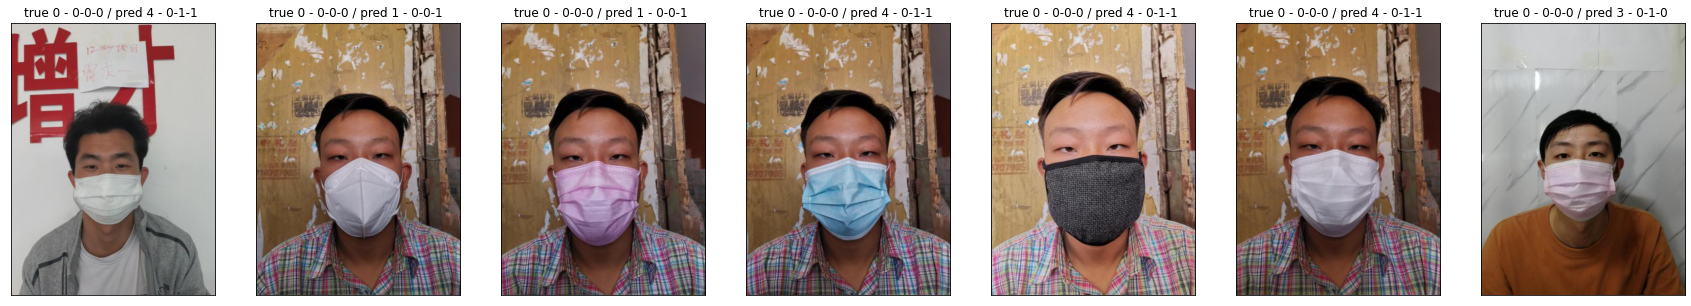

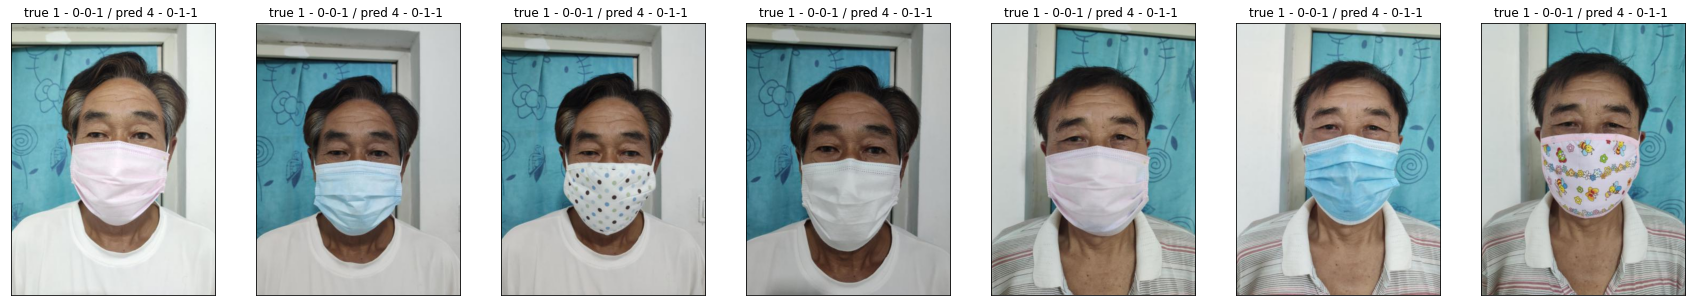

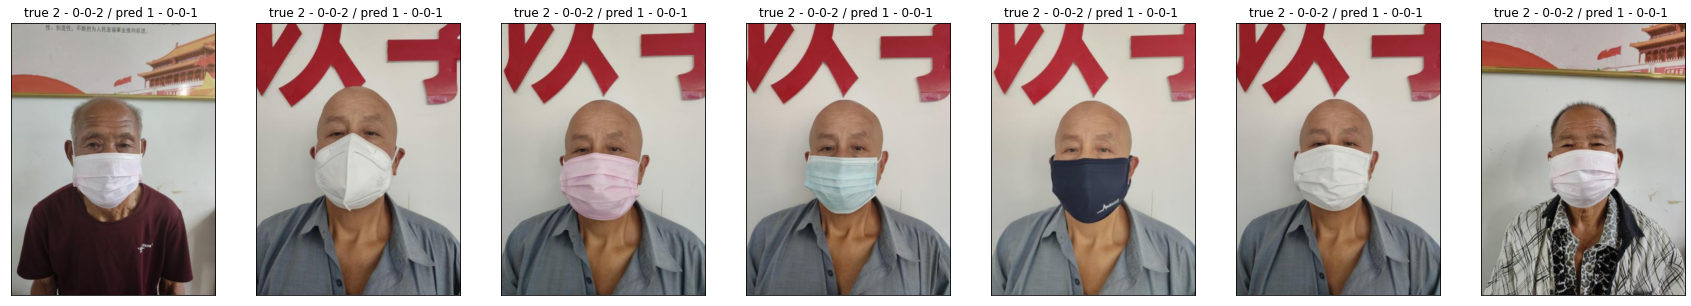

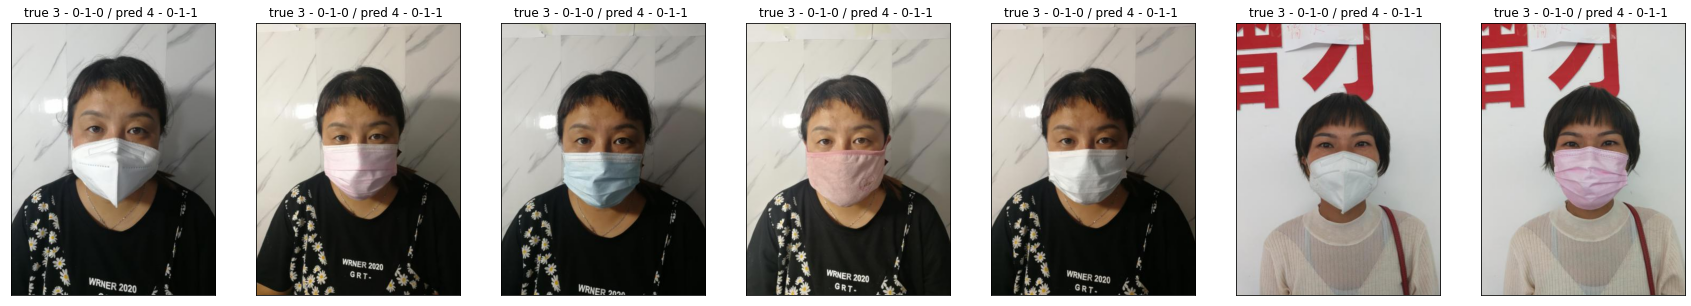

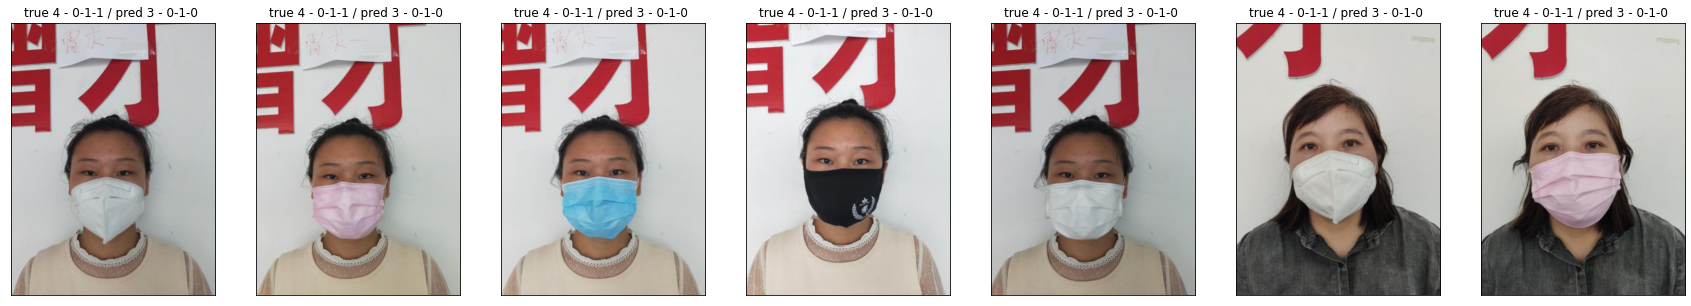

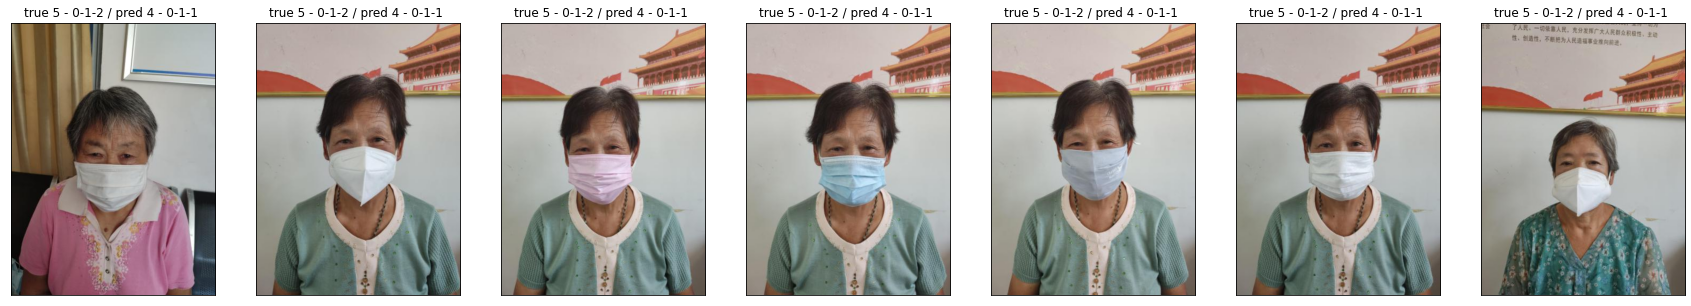

In [21]:
# labels 로 masks, genders, ages 역추적
labels2masks_genders_ages = {}
for line in train_df[~(train_df.duplicated(subset=[config.tagets_col]))].iloc:
    labels2masks_genders_ages[line[config.tagets_col]] = str(line['masks']) + '-' + str(line['genders']) + '-' + str(line['ages'])

# 틀린 이미지 시각화
image_show_df = train_df.iloc[idx_li, :].reset_index(drop =True)
image_show_df['pred_labels'] = pred_labels
false_image_show_df = image_show_df[image_show_df[config.tagets_col] != image_show_df['pred_labels']]
labels_li = [i for i in range(config.num_classes)]
for labels in labels_li:
    _false_image_show_df = false_image_show_df[false_image_show_df[config.tagets_col] == labels]
    path_labels_pred_labels_li = _false_image_show_df[['path', config.tagets_col, 'pred_labels']].values[:7]
    
    idx = 0
    fig, ax = plt.subplots(1, 7, figsize = (30, 15))
    ax = ax.flatten()
    for path_labels_pred_labels in path_labels_pred_labels_li:
        img = Image.open(path_labels_pred_labels[0])
        img = np.array(img)
        ax[idx].imshow(img)
        ax[idx].set_title(f'true {path_labels_pred_labels[1]} - {labels2masks_genders_ages[path_labels_pred_labels[1]]} / pred {path_labels_pred_labels[2]} - {labels2masks_genders_ages[path_labels_pred_labels[2]]} ')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        idx += 1
    plt.show()

# 저장

In [22]:
submission.to_csv(os.path.join(config.submission_dir, config.file_name), index=False)
submission.head()

ImageID  ans
0  cbc5c6e168e63498590db46022617123f1fe1268.jpg    1
1  0e72482bf56b3581c081f7da2a6180b8792c7089.jpg    5
2  b549040c49190cedc41327748aeb197c1670f14d.jpg    1
3  4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg    1
4  248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg    0